# PhD: EStreams variables visualization


Author: Thiago Nascimento (thiago.nascimento@eawag.ch)

This notebook is used for exploring the many catchment variables avaialable from EStreams and visualization with potential use in posterior modelling. EStreams has currently 17,130 catchments, but with different areas, time-series avaialbility and different attributes/influences. This analysis encompasses:

* Filtering the data.
* Visualization.
* Exporting the subset of data.


# Import modules

In [1]:
import pandas as pd
import numpy as np
import tqdm
import os
import geopandas as gpd
import networkx as nx
from shapely.geometry import Polygon, Point
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import warnings
warnings.simplefilter(action='ignore', category=Warning)
from utils.plots import add_circular_legend, plot_variable_subplot, generate_legend_and_color_mapping


# Configurations

In [2]:
# Only editable variables:
# Relative path to your local directory
PATH = "../.."

# Set the directory:
os.chdir(PATH)

# Import data

### - Network information

In [3]:
network_estreams = pd.read_csv('data/EStreams/streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

network_estreams

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,num_continuous_days,num_days_gaps,num_days_reliable,num_days_noflag,num_days_suspect,gauge_flag,duplicated_suspect,watershed_group,gauges_upstream,nested_catchments
basin_id,,,,,,,,,,,,,,,,,,,,,
AT000001,200014,Bangs,AT,AT_EHYD,Rhein,9.534835,47.273748,9.534835,47.273748,420,...,9497,0.0,0.0,9497.0,0.0,B,['CH000197'],1,16,"['AT000001', 'CH000010', 'CH000046', 'CH000048..."
AT000002,200048,Schruns (Vonbunweg),AT,AT_EHYD,Litz,9.913677,47.080301,9.913677,47.080301,673,...,23103,0.0,0.0,23103.0,0.0,B,['CH000221'],1,1,['AT000002']
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,579,...,13513,0.0,0.0,13513.0,0.0,B,['CH000215'],1,2,"['AT000002', 'AT000003', 'CH000221']"
AT000004,200592,Kloesterle (OEBB),AT,AT_EHYD,Alfenz,10.061843,47.128994,10.061843,47.128994,1014,...,8765,0.0,0.0,8765.0,0.0,B,['CH000227'],1,1,['AT000004']
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,564,...,10957,0.0,0.0,10957.0,0.0,B,['CH000214'],1,3,"['AT000005', 'CH000214']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAGR0017,6682300,BASHTANOVKA,UA,UA_GRDC,KACHA,33.894739,44.691884,33.900000,44.683333,NaN,...,3652,0.0,0.0,3652.0,0.0,B,NaN,1988,1,['UAGR0017']
UAGR0018,6682500,YALTA,UA,UA_GRDC,DERE-KIOY,34.166667,44.500000,34.166667,44.500000,16,...,3652,0.0,0.0,3652.0,0.0,B,NaN,1989,1,['UAGR0018']
UAGR0019,6683010,PIONERSKOE,UA,UA_GRDC,SALHYR,34.199841,44.887685,34.200000,44.883333,307,...,3652,0.0,0.0,3652.0,0.0,B,NaN,1990,1,['UAGR0019']


###  - Signatures

In [5]:
estreams_signatures = pd.read_csv('data/EStreams/hydroclimatic_signatures/estreams_hydrometeo_signatures_v02.csv', encoding='utf-8')
estreams_signatures.set_index("basin_id", inplace = True)

# Mapping dictionary for reclassification
time_mapping = {
    'Fall': 1, 
    'Winter': 2,  
    'Spring': 3,  
    'Summer': 4, 
}

# Reclassify time classes using the mapping dictionary
estreams_signatures['hp_time'] = estreams_signatures['hp_time'].map(time_mapping)
estreams_signatures['lp_time'] = estreams_signatures['lp_time'].map(time_mapping)

# Subset the signatures to be used (only variables, not dates and number of measurments):
estreams_signatures = estreams_signatures.iloc[:, 0:-6]
estreams_signatures

,q_mean,q_runoff_ratio,q_elas_Sankarasubramanian,slope_sawicz,baseflow_index,hfd_mean,hfd_std,q_5,q_95,hq_freq,...,pet_mean,aridity,p_seasonality,frac_snow,hp_freq,hp_dur,hp_time,lp_freq,lp_dur,lp_time
basin_id,,,,,,,,,,,,,,,,,,,,,
AT000001,2.824,0.727,1.266,1.505,0.760,237.600,12.858,1.029,6.607,0.077,...,1.499,0.395,0.309,0.326,13.239,1.172,4.0,198.993,3.561,1.0
AT000002,3.898,1.004,1.223,2.467,0.720,247.952,10.932,0.980,10.727,0.964,...,1.526,0.390,0.331,0.332,15.389,1.215,4.0,204.041,3.576,1.0
AT000003,0.915,0.247,1.802,0.979,0.687,233.361,27.141,0.404,2.819,6.136,...,1.516,0.411,0.346,0.337,15.212,1.203,4.0,202.001,3.592,1.0
AT000004,5.079,1.319,0.324,2.188,0.747,242.783,10.736,1.499,13.295,0.042,...,1.445,0.384,0.338,0.361,15.956,1.217,4.0,205.803,3.598,1.0
AT000005,3.319,0.806,0.820,1.967,0.756,239.207,14.642,1.064,7.692,0.233,...,1.814,0.448,0.328,0.200,15.266,1.186,4.0,201.796,3.547,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAGR0017,0.150,0.088,2.387,NaN,0.354,189.111,72.114,0.000,0.797,81.511,...,2.196,1.354,-0.276,0.183,21.817,1.264,2.0,270.637,5.789,4.0
UAGR0018,0.475,0.266,2.041,NaN,0.207,160.444,42.925,0.000,3.631,60.508,...,2.148,1.270,-0.290,0.198,21.849,1.263,2.0,268.322,5.700,4.0
UAGR0019,0.312,0.194,2.893,NaN,0.354,184.667,59.422,0.000,1.412,127.517,...,2.216,1.494,-0.157,0.172,22.917,1.271,2.0,273.598,5.876,4.0


### - Geology

In [6]:
estreams_geology = pd.read_csv('data/EStreams/attributes/static_attributes/estreams_geology_attributes.csv', encoding='utf-8')
estreams_geology.set_index("basin_id", inplace = True)

# Mapping dictionary for reclassification accroding to permeability
permeability_mapping = {
    'ev': 1,  # Evaporites
    'ig': 1,  # Ice and Glaciers
    'mt': 2,  # Metamorphics
    'pa': 1,  # Acid plutonic rocks
    'pb': 1,  # Basic plutonic rocks
    'pi': 2,  # Intermediate plutonic rocks
    'py': 2,  # Pyroclastics
    'sc': 2,  # Carbonate sedimentary rocks
    'sm': 2,  # Mixed sedimentary rocks
    'ss': 2,  # Siliciclastic sedimentary rocks
    'su': 4,  # Unconsolidated sediments
    'va': 1,  # Acid volcanic rocks
    'vb': 1,  # Basic volcanic rocks
    'vi': 2,  # Intermediate volcanic rocks
    'wb': 1,  # Water Bodies
    'nd': 999   # Precambrian rocks
}

# Reclassify geological classes using the mapping dictionary
estreams_geology['lit_dom_per'] = estreams_geology['lit_dom'].map(permeability_mapping)

# Initialize LabelEncoder (replace the text with numbers for the classes)
label_encoder = LabelEncoder()
# Fit and transform the 'lit_dom' column
estreams_geology['lit_dom'] = label_encoder.fit_transform(estreams_geology['lit_dom'])

# This part is to sum the percentage accroding to the classes:
# Create a dictionary to map permeability classes to corresponding columns
permeability_columns = {
    1: ['lit_fra_ev', 'lit_fra_ig', 'lit_fra_pa', 'lit_fra_pb', 'lit_fra_va', 'lit_fra_vb'],
    2: ['lit_fra_mt',  'lit_fra_pi', 'lit_fra_py',  'lit_fra_vi'],
    3: ['lit_fra_sc', 'lit_fra_sm'],
    4: ['lit_fra_ss', 'lit_fra_su']
}

# Iterate over the permeability columns and calculate the area for each class
for permeability_class, columns in permeability_columns.items():
    estreams_geology[f'area_perm_{permeability_class}'] = estreams_geology[columns].sum(axis=1)

## Drop unecessary columns:
estreams_geology = estreams_geology[["lit_dom", "bedrk_dep", "area_perm_1", "area_perm_2", "area_perm_3", "area_perm_4",
                                    "lit_fra_su", "lit_fra_ss", "lit_fra_sm", "lit_fra_sc", 'lit_fra_mt',  'lit_fra_pi', 'lit_fra_py', 'lit_fra_vi', 
                           'lit_fra_ev', 'lit_fra_ig', 'lit_fra_pa', 'lit_fra_pb', 'lit_fra_va', 'lit_fra_vb']]

# Rename the columns accordingly:
estreams_geology.columns = ["lit_dom", "bedrk_dep", "perc_imp", "perc_low_perm", "perc_medium_perm", "perc_high_perm", 
                           "lit_fra_su", "lit_fra_ss", "lit_fra_sm", "lit_fra_sc", 'lit_fra_mt',  'lit_fra_pi', 'lit_fra_py', 'lit_fra_vi', 
                           'lit_fra_ev', 'lit_fra_ig', 'lit_fra_pa', 'lit_fra_pb', 'lit_fra_va', 'lit_fra_vb']

estreams_geology

,lit_dom,bedrk_dep,perc_imp,perc_low_perm,perc_medium_perm,perc_high_perm,lit_fra_su,lit_fra_ss,lit_fra_sm,lit_fra_sc,lit_fra_mt,lit_fra_pi,lit_fra_py,lit_fra_vi,lit_fra_ev,lit_fra_ig,lit_fra_pa,lit_fra_pb,lit_fra_va,lit_fra_vb
basin_id,,,,,,,,,,,,,,,,,,,,
AT000001,8,1.124,5.886,23.654,44.274,25.952,22.064,3.888,5.521,38.753,23.464,0.19,0.0,0.0,0.0,0.553,2.657,0.042,0.776,1.858
AT000002,2,0.565,0.000,88.549,11.451,0.000,0.000,0.000,7.270,4.181,88.549,0.00,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000
AT000003,2,0.593,0.115,84.653,15.163,0.070,0.070,0.000,1.969,13.194,84.653,0.00,0.0,0.0,0.0,0.112,0.000,0.000,0.000,0.003
AT000004,2,0.564,0.000,59.940,40.060,0.000,0.000,0.000,0.000,40.060,59.940,0.00,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000
AT000005,8,0.445,0.000,15.582,82.950,0.000,0.000,0.000,0.885,82.065,15.582,0.00,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAGR0017,10,0.921,0.000,0.000,42.724,57.276,0.000,57.276,0.000,42.724,0.000,0.00,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000
UAGR0018,8,0.808,0.000,0.000,85.801,14.198,0.000,14.198,6.341,79.460,0.000,0.00,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000
UAGR0019,8,0.942,0.000,0.000,85.825,14.175,0.000,14.175,0.000,85.825,0.000,0.00,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000


### - Geology (Fabrizio Europe)

In [7]:
estreams_geology_ff_europe = pd.read_csv("data/new_attributes/estreams_geology_europe_level3_attributes.csv", encoding='utf-8')
estreams_geology_ff_europe.set_index("basin_id", inplace = True)

# This part is to sum the percentage accroding to the classes:
# Create a dictionary to map permeability classes to corresponding columns
permeability_columns = {
    1: ["lit_fra_Conglomerates", "lit_fra_Conglomerates and sands", "lit_fra_Gravels", 
        "lit_fra_Sands", "lit_fra_Sandstones", "lit_fra_Sandstones and sands"],
    
    2: ["lit_fra_Conglomerates and clays", "lit_fra_Gneisses", "lit_fra_Limestones", 
        "lit_fra_Limestones and sands", "lit_fra_Sandstones and clays", "lit_fra_Sandstones and marls",
        "lit_fra_Limestones and clays", "lit_fra_Limestones and marls", "lit_fra_Marlstones and sands"],
    
    3: ["lit_fra_Clays", "lit_fra_Claystones and clays", "lit_fra_Inland water", 
        "lit_fra_Marbles","lit_fra_Marls", "lit_fra_Marlstones", "lit_fra_Marlstones and clays", 
        "lit_fra_Marlstones and marls", "lit_fra_Phyllites",
        "lit_fra_Plutonic rocks", "lit_fra_Quartzites", "lit_fra_Schists",
        "lit_fra_Shales", "lit_fra_Silts", "lit_fra_Snow field / ice field", 
        "lit_fra_Volcanic rocks"]
}


# Iterate over the permeability columns and calculate the area for each class
for permeability_class, columns in permeability_columns.items():
    estreams_geology_ff_europe[f'area_perm_{permeability_class}'] = estreams_geology_ff_europe[columns].sum(axis=1)

## Drop unecessary columns:
estreams_geology_ff_europe = estreams_geology_ff_europe[["area_perm_1", "area_perm_2", "area_perm_3"]]

estreams_geology_ff_europe.columns = ["perm_mos_euro", "semiperm_mos_euro", "imper_mos_euro"]
estreams_geology_ff_europe

,perm_mos_euro,semiperm_mos_euro,imper_mos_euro
basin_id,,,
AT000001,9.347,61.887,28.768
AT000002,1.233,69.010,29.757
AT000003,8.263,62.357,29.380
AT000004,0.000,83.669,16.330
AT000005,0.298,79.307,20.395
...,...,...,...
UAGR0017,15.677,18.972,65.351
UAGR0018,0.000,43.210,56.790
UAGR0019,1.644,45.958,52.398


In [8]:
#import pandas as pd

# Load the dataset
estreams_geology_ff_europe = pd.read_csv("data/new_attributes/estreams_geology_europe_level3_attributes.csv", encoding='utf-8')
estreams_geology_ff_europe.set_index("basin_id", inplace=True)

# Create a dictionary to map permeability classes to corresponding columns
permeability_columns = {
    "high": ["lit_fra_Conglomerates", "lit_fra_Conglomerates and sands", "lit_fra_Gravels", 
             "lit_fra_Sands", "lit_fra_Sandstones", "lit_fra_Sandstones and sands"],
    
    "medium": ["lit_fra_Conglomerates and clays", "lit_fra_Gneisses", "lit_fra_Limestones", 
               "lit_fra_Limestones and sands", "lit_fra_Sandstones and clays", "lit_fra_Sandstones and marls",
               "lit_fra_Limestones and clays", "lit_fra_Limestones and marls", "lit_fra_Marlstones and sands"],
    
    "lower": ["lit_fra_Claystones and clays", "lit_fra_Marbles",
              "lit_fra_Marls", "lit_fra_Marlstones", "lit_fra_Marlstones and clays", 
              "lit_fra_Marlstones and marls", "lit_fra_Phyllites", "lit_fra_Schists",
              "lit_fra_Silts"],
    
    "impermeable": ["lit_fra_Plutonic rocks", "lit_fra_Volcanic rocks", 
                    "lit_fra_Inland water", "lit_fra_Snow field / ice field",
                    "lit_fra_Clays",  'lit_fra_Quartzites', "lit_fra_Shales"]
}

# Iterate over the permeability columns and calculate the area for each class
for permeability_class, columns in permeability_columns.items():
    estreams_geology_ff_europe[f'area_perm_{permeability_class}'] = estreams_geology_ff_europe[columns].sum(axis=1)

# Drop unnecessary columns
estreams_geology_ff_europe = estreams_geology_ff_europe[["area_perm_high", "area_perm_medium", "area_perm_lower", "area_perm_impermeable"]]

# Rename the columns
estreams_geology_ff_europe.columns = ["perm_high_euro", "perm_medium_euro", "perm_lower_euro", "perm_impermeable_euro"]

# Display the updated DataFrame
estreams_geology_ff_europe

,perm_high_euro,perm_medium_euro,perm_lower_euro,perm_impermeable_euro
basin_id,,,,
AT000001,9.347,61.887,19.771,8.997
AT000002,1.233,69.010,0.000,29.757
AT000003,8.263,62.357,6.451,22.929
AT000004,0.000,83.669,0.000,16.330
AT000005,0.298,79.307,19.380,1.015
...,...,...,...,...
UAGR0017,15.677,18.972,5.516,59.835
UAGR0018,0.000,43.210,0.000,56.790
UAGR0019,1.644,45.958,26.712,25.686


In [9]:
import pandas as pd

# Load the dataset
estreams_geology_ff_europe = pd.read_csv("data/new_attributes/estreams_geology_europe_level3_attributes.csv", encoding='utf-8')
estreams_geology_ff_europe.set_index("basin_id", inplace=True)

# Create a dictionary to map permeability classes to corresponding columns
permeability_columns = {
    "high": ["lit_fra_Conglomerates", "lit_fra_Conglomerates and sands", "lit_fra_Gravels", 
             "lit_fra_Sands", "lit_fra_Sandstones", "lit_fra_Sandstones and sands"],
    
    "medium": ["lit_fra_Conglomerates and clays", "lit_fra_Gneisses", "lit_fra_Limestones", 
               "lit_fra_Limestones and sands", "lit_fra_Sandstones and clays", "lit_fra_Sandstones and marls",
               "lit_fra_Limestones and clays", "lit_fra_Limestones and marls", "lit_fra_Marlstones and sands"],
    
    "lower": ["lit_fra_Claystones and clays", "lit_fra_Marbles",
              "lit_fra_Marls", "lit_fra_Marlstones", "lit_fra_Marlstones and clays", 
              "lit_fra_Marlstones and marls", "lit_fra_Phyllites", "lit_fra_Schists",
              "lit_fra_Silts"],
    
    "impermeable": ["lit_fra_Plutonic rocks", "lit_fra_Volcanic rocks", 
                    "lit_fra_Inland water", "lit_fra_Snow field / ice field",
                    "lit_fra_Clays",  'lit_fra_Quartzites', "lit_fra_Shales"]
}

# Iterate over the permeability columns and calculate the area for each class
for permeability_class, columns in permeability_columns.items():
    estreams_geology_ff_europe[f'area_perm_{permeability_class}'] = estreams_geology_ff_europe[columns].sum(axis=1)

# Drop unnecessary columns
estreams_geology_ff_europe = estreams_geology_ff_europe[["area_perm_high", "area_perm_medium", "area_perm_lower", "area_perm_impermeable"]]

# Rename the columns
estreams_geology_ff_europe.columns = ["perm_high_euro", "perm_medium_euro", "perm_lower_euro", "perm_impermeable_euro"]

# Display the updated DataFrame
estreams_geology_ff_europe

,perm_high_euro,perm_medium_euro,perm_lower_euro,perm_impermeable_euro
basin_id,,,,
AT000001,9.347,61.887,19.771,8.997
AT000002,1.233,69.010,0.000,29.757
AT000003,8.263,62.357,6.451,22.929
AT000004,0.000,83.669,0.000,16.330
AT000005,0.298,79.307,19.380,1.015
...,...,...,...,...
UAGR0017,15.677,18.972,5.516,59.835
UAGR0018,0.000,43.210,0.000,56.790
UAGR0019,1.644,45.958,26.712,25.686


In [10]:
# Load the dataset
estreams_geology_ff_europe = pd.read_csv("data/new_attributes/estreams_geology_europe_level3_attributes.csv", encoding='utf-8')
estreams_geology_ff_europe.set_index("basin_id", inplace=True)

# Create a dictionary to map permeability classes to corresponding columns
permeability_columns = {
    "high": ["lit_fra_Conglomerates", "lit_fra_Conglomerates and sands", "lit_fra_Gravels", 
             "lit_fra_Sands","lit_fra_Limestones", 
               "lit_fra_Limestones and sands", "lit_fra_Sandstones", "lit_fra_Sandstones and sands"],
    
    "medium": [],
    
    "lower": ["lit_fra_Claystones and clays", "lit_fra_Marbles","lit_fra_Gneisses", 
              "lit_fra_Marls", "lit_fra_Marlstones", "lit_fra_Marlstones and clays", 
              "lit_fra_Marlstones and marls", "lit_fra_Phyllites", "lit_fra_Schists",
              "lit_fra_Silts", "lit_fra_Sandstones and clays", "lit_fra_Sandstones and marls",
               "lit_fra_Limestones and clays", "lit_fra_Limestones and marls", "lit_fra_Marlstones and sands",
              "lit_fra_Conglomerates and clays"],
    
    "impermeable": ["lit_fra_Plutonic rocks", "lit_fra_Volcanic rocks", 
                    "lit_fra_Inland water", "lit_fra_Snow field / ice field",
                    "lit_fra_Clays",  'lit_fra_Quartzites', "lit_fra_Shales"]
}

# Iterate over the permeability columns and calculate the area for each class
for permeability_class, columns in permeability_columns.items():
    estreams_geology_ff_europe[f'area_perm_{permeability_class}'] = estreams_geology_ff_europe[columns].sum(axis=1)

# Drop unnecessary columns
estreams_geology_ff_europe = estreams_geology_ff_europe[["area_perm_high", "area_perm_medium", "area_perm_lower", "area_perm_impermeable"]]

# Rename the columns
estreams_geology_ff_europe.columns = ["perm_high_euro", "perm_medium_euro", "perm_lower_euro", "perm_impermeable_euro"]

# Display the updated DataFrame
estreams_geology_ff_europe

,perm_high_euro,perm_medium_euro,perm_lower_euro,perm_impermeable_euro
basin_id,,,,
AT000001,28.681,0.0,62.324,8.997
AT000002,8.471,0.0,61.772,29.757
AT000003,15.949,0.0,61.122,22.929
AT000004,41.265,0.0,42.404,16.330
AT000005,79.605,0.0,19.380,1.015
...,...,...,...,...
UAGR0017,20.003,0.0,20.162,59.835
UAGR0018,0.000,0.0,43.210,56.790
UAGR0019,1.644,0.0,72.670,25.686


In [11]:
# Load the dataset
estreams_geology_ff_europe = pd.read_csv("data/new_attributes/estreams_geology_europe_level3_attributes.csv", encoding='utf-8')
estreams_geology_ff_europe.set_index("basin_id", inplace=True)

# Create a dictionary to map permeability classes to corresponding columns
permeability_columns = {
    "high": ["lit_fra_Conglomerates", "lit_fra_Conglomerates and sands", "lit_fra_Gravels", 
             "lit_fra_Sands", "lit_fra_Sandstones", "lit_fra_Sandstones and sands"],
    
    "medium": ["lit_fra_Conglomerates and clays", "lit_fra_Limestones", 
               "lit_fra_Limestones and sands", "lit_fra_Sandstones and clays", "lit_fra_Sandstones and marls",
               "lit_fra_Limestones and clays", "lit_fra_Limestones and marls", "lit_fra_Marlstones and sands"],
    
    "lower": ["lit_fra_Claystones and clays", "lit_fra_Marbles",
              "lit_fra_Marls", "lit_fra_Marlstones", "lit_fra_Marlstones and clays", 
              "lit_fra_Marlstones and marls", "lit_fra_Phyllites", "lit_fra_Schists", "lit_fra_Gneisses",
              "lit_fra_Silts"],
    
    "impermeable": ["lit_fra_Plutonic rocks", "lit_fra_Volcanic rocks", 
                    "lit_fra_Inland water", "lit_fra_Snow field / ice field",
                    "lit_fra_Clays",  'lit_fra_Quartzites', "lit_fra_Shales"]
}

# Iterate over the permeability columns and calculate the area for each class
for permeability_class, columns in permeability_columns.items():
    estreams_geology_ff_europe[f'area_perm_{permeability_class}'] = estreams_geology_ff_europe[columns].sum(axis=1)

# Drop unnecessary columns
estreams_geology_ff_europe = estreams_geology_ff_europe[["area_perm_high", "area_perm_medium", "area_perm_lower", "area_perm_impermeable",
                                                        "lit_fra_Conglomerates", "lit_fra_Conglomerates and sands", "lit_fra_Gravels", 
                                                        "lit_fra_Sands", "lit_fra_Sandstones", "lit_fra_Sandstones and sands"]]

# Rename the columns
estreams_geology_ff_europe.columns = ["perm_high_euro", "perm_medium_euro", "perm_lower_euro", "perm_impermeable_euro",
                                     "lit_fra_Conglomerates", "lit_fra_Conglomerates and sands", "lit_fra_Gravels", 
                                     "lit_fra_Sands", "lit_fra_Sandstones", "lit_fra_Sandstones and sands"]

# Display the updated DataFrame
estreams_geology_ff_europe

,perm_high_euro,perm_medium_euro,perm_lower_euro,perm_impermeable_euro,lit_fra_Conglomerates,lit_fra_Conglomerates and sands,lit_fra_Gravels,lit_fra_Sands,lit_fra_Sandstones,lit_fra_Sandstones and sands
basin_id,,,,,,,,,,
AT000001,9.347,35.822,45.836,8.997,0.0,0.0,7.103,2.244,0.000,0.0
AT000002,1.233,7.238,61.772,29.757,0.0,0.0,1.233,0.000,0.000,0.0
AT000003,8.263,10.074,58.734,22.929,0.0,0.0,8.263,0.000,0.000,0.0
AT000004,0.000,41.265,42.404,16.330,0.0,0.0,0.000,0.000,0.000,0.0
AT000005,0.298,79.307,19.380,1.015,0.0,0.0,0.298,0.000,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...
UAGR0017,15.677,18.972,5.516,59.835,0.0,0.0,15.677,0.000,0.000,0.0
UAGR0018,0.000,43.210,0.000,56.790,0.0,0.0,0.000,0.000,0.000,0.0
UAGR0019,1.644,45.958,26.712,25.686,0.0,0.0,1.644,0.000,0.000,0.0


### - Vegetation

In [12]:
estreams_vegetation= pd.read_csv("data/EStreams/attributes/static_attributes/estreams_vegetation_attributes.csv", encoding='utf-8')
estreams_vegetation.set_index("basin_id", inplace = True)

# Here we select only these two variables as representative
estreams_vegetation = estreams_vegetation[["lai_mean", "ndvi_mean"]]
estreams_vegetation

,lai_mean,ndvi_mean
basin_id,,
AT000001,0.092,0.329
AT000002,0.089,0.342
AT000003,0.087,0.313
AT000004,0.073,0.276
AT000005,0.086,0.311
...,...,...
UAGR0017,0.195,0.599
UAGR0018,0.152,0.576
UAGR0019,0.145,0.535


### - Snow cover

In [13]:
estreams_snowcover = pd.read_csv("data/EStreams/attributes/static_attributes/estreams_snowcover_attributes.csv", encoding='utf-8')
estreams_snowcover.set_index("basin_id", inplace = True)

# Here we select only these two variables as representative
estreams_snowcover = estreams_snowcover[["sno_cov_mean"]]
estreams_snowcover

,sno_cov_mean
basin_id,
AT000001,33.844
AT000002,36.284
AT000003,36.927
AT000004,40.210
AT000005,34.486
...,...
UAGR0017,3.805
UAGR0018,6.159
UAGR0019,4.928


### - Meteorology

In [14]:
estreams_meteodensity = pd.read_csv('data/EStreams/attributes/static_attributes/estreams_meteorology_density.csv', encoding='utf-8')
estreams_meteodensity.set_index("basin_id", inplace = True)

# Here we select only these variables as representative:
estreams_meteodensity = estreams_meteodensity[["stations_num_p_mean"]]

estreams_meteodensity.head()

,stations_num_p_mean
basin_id,
AT000001,22.0
AT000002,14.0
AT000003,18.0
AT000004,7.0
AT000005,10.0


### - Topography

In [15]:
estreams_topography = pd.read_csv('data/EStreams/attributes/static_attributes/estreams_topography_attributes.csv', encoding='utf-8')
estreams_topography.set_index("basin_id", inplace = True)
estreams_topography

,ele_mt_max,ele_mt_mean,ele_mt_min,slp_dg_mean,flat_area_fra,steep_area_fra,elon_ratio,strm_dens
basin_id,,,,,,,,
AT000001,3555.408,1874.076,420.622,24.122,3.395,78.590,0.612,0.151
AT000002,2803.984,1773.178,674.209,26.095,0.463,87.662,0.539,0.151
AT000003,3293.054,1843.003,583.510,25.735,1.497,82.952,0.577,0.141
AT000004,2878.033,1890.429,1022.324,27.324,0.351,88.023,0.587,0.095
AT000005,2938.964,1772.902,567.275,28.647,1.719,83.629,0.612,0.134
...,...,...,...,...,...,...,...,...
UAGR0017,1537.278,564.291,161.399,11.810,4.283,24.393,0.634,0.129
UAGR0018,1511.835,749.565,16.793,19.438,2.114,61.735,0.621,0.024
UAGR0019,1449.416,653.127,306.877,9.655,17.055,20.545,0.739,0.112


### - Hydrology

In [16]:
estreams_hydrology = pd.read_csv('data/EStreams/attributes/static_attributes/estreams_hydrology_attributes.csv', encoding='utf-8')
estreams_hydrology.set_index("basin_id", inplace = True)

# Here we select only these variables as representative
estreams_hydrology = estreams_hydrology[["dam_num", "res_num", "lakes_num", "lakes_tot_area", "lakes_tot_vol"]]
estreams_hydrology

,dam_num,res_num,lakes_num,lakes_tot_area,lakes_tot_vol
basin_id,,,,,
AT000001,23.0,10.0,10.0,6.62,542.33
AT000002,0.0,0.0,0.0,0.00,0.00
AT000003,4.0,4.0,3.0,1.46,12.91
AT000004,0.0,0.0,0.0,0.00,0.00
AT000005,1.0,1.0,1.0,0.89,8.27
...,...,...,...,...,...
UAGR0017,0.0,0.0,1.0,1.43,16.43
UAGR0018,0.0,0.0,0.0,0.00,0.00
UAGR0019,0.0,0.0,1.0,0.31,1.54


### - Soils

In [17]:
estreams_soil = pd.read_csv('data/EStreams/attributes/static_attributes/estreams_soil_attributes.csv', encoding='utf-8')
estreams_soil.set_index("basin_id", inplace = True)

# Here we select only these variables as representative
estreams_soil = estreams_soil[['root_dep_mean', 'root_dep_max', 'root_dep_min',
       'soil_tawc_mean', 'soil_fra_sand_mean', 'soil_fra_silt_mean',
       'soil_fra_clay_mean', 'soil_fra_grav_mean', 'soil_bd_mean','soil_oc_mean']]

estreams_soil

,root_dep_mean,root_dep_max,root_dep_min,soil_tawc_mean,soil_fra_sand_mean,soil_fra_silt_mean,soil_fra_clay_mean,soil_fra_grav_mean,soil_bd_mean,soil_oc_mean
basin_id,,,,,,,,,,
AT000001,81.571,130.0,0.0,28.738,58.196,16.337,7.973,9.062,1.303,1.218
AT000002,58.600,70.0,30.0,46.474,54.920,29.650,15.430,8.140,1.502,1.820
AT000003,51.660,130.0,0.0,45.044,49.262,30.836,16.883,10.294,1.425,1.714
AT000004,49.412,70.0,30.0,49.256,39.956,40.088,19.956,13.044,1.409,1.771
AT000005,31.781,100.0,0.0,44.098,39.795,38.151,20.685,17.658,1.384,1.836
...,...,...,...,...,...,...,...,...,...,...
UAGR0017,128.620,130.0,40.0,51.371,23.184,29.245,47.571,9.939,1.246,1.198
UAGR0018,73.061,130.0,40.0,64.165,30.592,39.122,30.286,7.469,1.066,2.340
UAGR0019,130.000,130.0,130.0,51.029,23.115,29.123,47.761,10.049,1.251,1.178


### - Landcover

In [18]:
estreams_landcover = pd.read_csv('data/EStreams/attributes/temporal_attributes/estreams_landcover_attributes.csv', encoding='utf-8')
estreams_landcover.set_index("basin_id", inplace = True)
estreams_landcover

# We have more than 20 classes, so it is better if we aggregate the classes in more representative ones:
# * 1. Urban, 2. Non irrigated aggriculture, 3. Irrigated aggriculture, 4. grassland and 5. forests

def aggregate_columns(df, years):
    # Initialize a dictionary to store aggregated columns
    aggregated_columns = {}

    # Iterate through each year
    for year in years:
        # Iterate through each column in the DataFrame
        for column in df.columns:
            # Check if the column name contains the specified year and the number is between 300 and 315 for forest
            if f'_{year}_' in column and 300 <= int(column.split('_')[-1]) < 315:
                prefix = '_'.join(column.split('_')[:-1]) + "_forest"
                if prefix in aggregated_columns:
                    aggregated_columns[prefix].append(column)
                else:
                    aggregated_columns[prefix] = [column]
            # Check if the column name contains the specified year and the number is between 315 and 400 for grass
            elif f'_{year}_' in column and 315 <= int(column.split('_')[-1]) < 400:
                prefix = '_'.join(column.split('_')[:-1]) + "_grass"
                if prefix in aggregated_columns:
                    aggregated_columns[prefix].append(column)
                else:
                    aggregated_columns[prefix] = [column]
            # Check if the column name contains the specified year and the number is between 200 and 300 for agriculture
            elif f'_{year}_' in column and 212 <= int(column.split('_')[-1]) < 300:
                prefix = '_'.join(column.split('_')[:-1]) + "_Agric"
                if prefix in aggregated_columns:
                    aggregated_columns[prefix].append(column)
                else:
                    aggregated_columns[prefix] = [column]
        
            # Check if the column name contains the specified year and the number is between 200 and 300 for agriculture
            elif f'_{year}_' in column and 200 <= int(column.split('_')[-1]) < 212:
                prefix = '_'.join(column.split('_')[:-1]) + "_NonIrriAgri"
                if prefix in aggregated_columns:
                    aggregated_columns[prefix].append(column)
                else:
                    aggregated_columns[prefix] = [column]

             # Check if the column name contains the specified year and the number is between 200 and 300 for agriculture
            elif f'_{year}_' in column and 111 <= int(column.split('_')[-1]) <= 124:
                prefix = '_'.join(column.split('_')[:-1]) + "_urban"
                if prefix in aggregated_columns:
                    aggregated_columns[prefix].append(column)
                else:
                    aggregated_columns[prefix] = [column]                   
    # Iterate through the aggregated_columns dictionary and create new aggregated columns
    for prefix, columns in aggregated_columns.items():
        # Aggregate the columns by summing them along the columns axis
        df[prefix] = df[columns].sum(axis=1)
        # Drop the original columns
        df.drop(columns, axis=1, inplace=True)

# List of years to iterate over
years = [1990, 2000, 2006, 2012, 2018]

# Call the function to aggregate columns for each year
aggregate_columns(estreams_landcover, years)


# Filter only the columns already resampled:
estreams_landcover = estreams_landcover.iloc[:, -25:]

# Subset only one year to avoid co-correlation
estreams_landcover = estreams_landcover[["lulc_2006_urban", "lulc_2006_NonIrriAgri", "lulc_2006_Agric", "lulc_2006_forest", 
                                         "lulc_2006_grass"]]
estreams_landcover["lulc_2006_agriculture"] = estreams_landcover.lulc_2006_NonIrriAgri + estreams_landcover.lulc_2006_Agric

estreams_landcover.head()

,lulc_2006_urban,lulc_2006_NonIrriAgri,lulc_2006_Agric,lulc_2006_forest,lulc_2006_grass,lulc_2006_agriculture
basin_id,,,,,,
AT000001,0.020,0.019,0.108,0.268,0.581,0.127
AT000002,0.029,0.000,0.051,0.331,0.577,0.051
AT000003,0.031,0.000,0.040,0.269,0.647,0.040
AT000004,0.023,0.000,0.031,0.177,0.739,0.031
AT000005,0.017,0.000,0.023,0.283,0.624,0.023


### - Irrigation

In [19]:
estreams_irrigation = pd.read_csv('data/EStreams/attributes/temporal_attributes/estreams_irrigation_yearly.csv', encoding='utf-8')
estreams_irrigation.set_index("date", inplace = True)
estreams_irrigation = estreams_irrigation.loc[[1990, 2005], :].T

estreams_irrigation.index.name = "basin_id"

estreams_irrigation.columns = ["irri_1990", "irri_2005"]

estreams_irrigation.head()

,irri_1990,irri_2005
basin_id,,
AT000001,23.025,29.307
AT000002,0.000,0.005
AT000003,0.000,0.204
AT000004,0.000,0.000
AT000005,0.000,0.084


### - Nested catchments list
* This part has the nested catchements upstream each gauge. 

In [20]:
nested_catchments = pd.DataFrame(network_estreams.nested_catchments)
nested_catchments

,nested_catchments
basin_id,
AT000001,"['AT000001', 'CH000010', 'CH000046', 'CH000048..."
AT000002,['AT000002']
AT000003,"['AT000002', 'AT000003', 'CH000221']"
AT000004,['AT000004']
AT000005,"['AT000005', 'CH000214']"
...,...
UAGR0017,['UAGR0017']
UAGR0018,['UAGR0018']
UAGR0019,['UAGR0019']


In [21]:
nested_catchments3 = pd.DataFrame(network_estreams.duplicated_suspect)
nested_catchments3

,duplicated_suspect
basin_id,
AT000001,['CH000197']
AT000002,['CH000221']
AT000003,['CH000215']
AT000004,['CH000227']
AT000005,['CH000214']
...,...
UAGR0017,NaN
UAGR0018,NaN
UAGR0019,NaN


In [22]:
# Convert the string representation of lists to actual lists
nested_catchments['nested_catchments'] = nested_catchments['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))
nested_catchments

,nested_catchments
basin_id,
AT000001,"[AT000001, CH000010, CH000046, CH000048, CH000..."
AT000002,[AT000002]
AT000003,"[AT000002, AT000003, CH000221]"
AT000004,[AT000004]
AT000005,"[AT000005, CH000214]"
...,...
UAGR0017,[UAGR0017]
UAGR0018,[UAGR0018]
UAGR0019,[UAGR0019]


In [23]:
# Test to check
network_estreams.loc[nested_catchments.loc["AT000002", 'nested_catchments']]

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,num_continuous_days,num_days_gaps,num_days_reliable,num_days_noflag,num_days_suspect,gauge_flag,duplicated_suspect,watershed_group,gauges_upstream,nested_catchments
basin_id,,,,,,,,,,,,,,,,,,,,,
AT000002,200048,Schruns (Vonbunweg),AT,AT_EHYD,Litz,9.913677,47.080301,9.913677,47.080301,673,...,23103,0.0,0.0,23103.0,0.0,B,['CH000221'],1,1,['AT000002']


In [24]:
nested_catchments

,nested_catchments
basin_id,
AT000001,"[AT000001, CH000010, CH000046, CH000048, CH000..."
AT000002,[AT000002]
AT000003,"[AT000002, AT000003, CH000221]"
AT000004,[AT000004]
AT000005,"[AT000005, CH000214]"
...,...
UAGR0017,[UAGR0017]
UAGR0018,[UAGR0018]
UAGR0019,[UAGR0019]


# Filtering the data

### - Concatenation

In [25]:
# Concatenate horizontally
network_estreams_concatenated = pd.concat([network_estreams, estreams_signatures, estreams_topography, estreams_geology, 
                                           estreams_geology_ff_europe, estreams_soil, estreams_vegetation, estreams_landcover,
                                           estreams_hydrology, estreams_snowcover, estreams_irrigation, estreams_meteodensity], axis=1)

network_estreams_concatenated

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,lulc_2006_agriculture,dam_num,res_num,lakes_num,lakes_tot_area,lakes_tot_vol,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean
basin_id,,,,,,,,,,,,,,,,,,,,,
AT000001,200014,Bangs,AT,AT_EHYD,Rhein,9.534835,47.273748,9.534835,47.273748,420,...,0.127,23.0,10.0,10.0,6.62,542.33,33.844,23.025,29.307,22.0
AT000002,200048,Schruns (Vonbunweg),AT,AT_EHYD,Litz,9.913677,47.080301,9.913677,47.080301,673,...,0.051,0.0,0.0,0.0,0.00,0.00,36.284,0.000,0.005,14.0
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,579,...,0.040,4.0,4.0,3.0,1.46,12.91,36.927,0.000,0.204,18.0
AT000004,200592,Kloesterle (OEBB),AT,AT_EHYD,Alfenz,10.061843,47.128994,10.061843,47.128994,1014,...,0.031,0.0,0.0,0.0,0.00,0.00,40.210,0.000,0.000,7.0
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,564,...,0.023,1.0,1.0,1.0,0.89,8.27,34.486,0.000,0.084,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAGR0017,6682300,BASHTANOVKA,UA,UA_GRDC,KACHA,33.894739,44.691884,33.900000,44.683333,NaN,...,0.000,0.0,0.0,1.0,1.43,16.43,3.805,0.000,0.000,3.0
UAGR0018,6682500,YALTA,UA,UA_GRDC,DERE-KIOY,34.166667,44.500000,34.166667,44.500000,16,...,0.000,0.0,0.0,0.0,0.00,0.00,6.159,0.000,0.000,2.0
UAGR0019,6683010,PIONERSKOE,UA,UA_GRDC,SALHYR,34.199841,44.887685,34.200000,44.883333,307,...,0.000,0.0,0.0,1.0,0.31,1.54,4.928,0.000,0.000,1.0


In [26]:
network_estreams_concatenated.loc["CH000001"].head(50)

gauge_id                                                                  2009
gauge_name                                                       Porte_du_Scex
gauge_country                                                               CH
gauge_provider                                                       CH_CAMELS
river                                                                    Rhône
lon_snap                                                                  6.89
lat_snap                                                                 46.35
lon                                                                       6.89
lat                                                                      46.35
elevation                                                                  377
area_official                                                           5239.4
area_estreams                                                         5239.706
area_flag                                           

##### - Time series length and catchment attributes

In [29]:
# First we filter the network dataframe:

# Here we select only high-quality areas delineations (888 or 999 excluded):
network_estreams_filtered = network_estreams_concatenated[network_estreams_concatenated.area_flag < 888]

# Area threshold (in km2):
network_estreams_filtered = network_estreams_filtered[network_estreams_filtered.area_estreams >= 50]
#network_estreams_filtered = network_estreams_filtered[network_estreams_filtered.area_estreams <= 100000]

# Number of years with valid measurements:
network_estreams_filtered = network_estreams_filtered[network_estreams_filtered.num_years >= 10]

# Last year with data (with that we make sure we have at least num_years (e.g. 20 years) after end_date (e.g. 1950):
network_estreams_filtered = network_estreams_filtered[network_estreams_filtered.end_date >= "1970"]

# Number of dams or reservoirs:
#network_estreams_filtered = network_estreams_filtered[network_estreams_filtered.dam_num <= 5]

# Filter the number of EObs precipitation stations within the catchments (e.g. 1 station):
#network_estreams_filtered = network_estreams_filtered[network_estreams_filtered.stations_num_p >= 1]

# Now we subset catchments that may have problems according to their signatures:
# Too high q_mean (q_mean > 10 mm/day):
network_estreams_filtered = network_estreams_filtered[network_estreams_filtered.q_mean < 10]

# Too high runoff ratio (Q/P > 1):
network_estreams_filtered = network_estreams_filtered[network_estreams_filtered.q_runoff_ratio <= 1]

# Availability of PET and P time-series (aridity):
network_estreams_filtered = network_estreams_filtered[~network_estreams_filtered["aridity"].isnull()]

# Save to another variable:
estreams_attributes = network_estreams_filtered.copy()

# Here we check the final catchments used:
network_estreams_filtered

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,lulc_2006_agriculture,dam_num,res_num,lakes_num,lakes_tot_area,lakes_tot_vol,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean
basin_id,,,,,,,,,,,,,,,,,,,,,
AT000001,200014,Bangs,AT,AT_EHYD,Rhein,9.534835,47.273748,9.534835,47.273748,420,...,0.127,23.0,10.0,10.0,6.62,542.33,33.844,23.025,29.307,22.0
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,579,...,0.040,4.0,4.0,3.0,1.46,12.91,36.927,0.000,0.204,18.0
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,564,...,0.023,1.0,1.0,1.0,0.89,8.27,34.486,0.000,0.084,10.0
AT000007,231688,Beschling,AT,AT_EHYD,Ill,9.678850,47.200301,9.678850,47.200301,485,...,0.058,7.0,6.0,5.0,2.67,23.90,32.887,0.000,0.399,40.0
AT000008,200501,Amerluegen,AT,AT_EHYD,Samina,9.614203,47.205978,9.614203,47.205978,603,...,0.016,0.0,0.0,0.0,0.00,0.00,27.201,0.000,0.000,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAGR0016,6681500,NOVOGOROZHENOYE,UA,UA_GRDC,INHUL,32.350000,47.516667,32.350000,47.516667,8,...,0.000,0.0,0.0,95.0,29.74,124.55,8.705,163.532,152.585,4.0
UAGR0017,6682300,BASHTANOVKA,UA,UA_GRDC,KACHA,33.894739,44.691884,33.900000,44.683333,NaN,...,0.000,0.0,0.0,1.0,1.43,16.43,3.805,0.000,0.000,3.0
UAGR0019,6683010,PIONERSKOE,UA,UA_GRDC,SALHYR,34.199841,44.887685,34.200000,44.883333,307,...,0.000,0.0,0.0,1.0,0.31,1.54,4.928,0.000,0.000,1.0


In [30]:
# Here we can check the results:
max_column = network_estreams_filtered['q_mean'].idxmax()
print("Value:", network_estreams_filtered['q_mean'].max(), 
      "Column with maximum q_mean value:", max_column)

Value: 6.461 Column with maximum q_mean value: NO000010


### - Duplicated suspects deletion
- At this part, when there is a duplicated suspect in our catchments list we keep only the catchemnt with the longest time-series.
- For example, FR001479 has 23 years of measurements, from 1969 to 1991, and has two duplicated suspects: [FR001477, FR001478].
- After our filter, we aim to keep only FR001479 in our final list, since it is the one with the longest number of measurements from the three.
- Eventually we mitigate the number of potential duplicates in our time-series.

In [31]:
# Remove the brackets and handle NaN values
network_estreams_filtered['duplicated_suspect'] = network_estreams_filtered['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x
)

network_estreams_filtered

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,lulc_2006_agriculture,dam_num,res_num,lakes_num,lakes_tot_area,lakes_tot_vol,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean
basin_id,,,,,,,,,,,,,,,,,,,,,
AT000001,200014,Bangs,AT,AT_EHYD,Rhein,9.534835,47.273748,9.534835,47.273748,420,...,0.127,23.0,10.0,10.0,6.62,542.33,33.844,23.025,29.307,22.0
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,579,...,0.040,4.0,4.0,3.0,1.46,12.91,36.927,0.000,0.204,18.0
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,564,...,0.023,1.0,1.0,1.0,0.89,8.27,34.486,0.000,0.084,10.0
AT000007,231688,Beschling,AT,AT_EHYD,Ill,9.678850,47.200301,9.678850,47.200301,485,...,0.058,7.0,6.0,5.0,2.67,23.90,32.887,0.000,0.399,40.0
AT000008,200501,Amerluegen,AT,AT_EHYD,Samina,9.614203,47.205978,9.614203,47.205978,603,...,0.016,0.0,0.0,0.0,0.00,0.00,27.201,0.000,0.000,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAGR0016,6681500,NOVOGOROZHENOYE,UA,UA_GRDC,INHUL,32.350000,47.516667,32.350000,47.516667,8,...,0.000,0.0,0.0,95.0,29.74,124.55,8.705,163.532,152.585,4.0
UAGR0017,6682300,BASHTANOVKA,UA,UA_GRDC,KACHA,33.894739,44.691884,33.900000,44.683333,NaN,...,0.000,0.0,0.0,1.0,1.43,16.43,3.805,0.000,0.000,3.0
UAGR0019,6683010,PIONERSKOE,UA,UA_GRDC,SALHYR,34.199841,44.887685,34.200000,44.883333,307,...,0.000,0.0,0.0,1.0,0.31,1.54,4.928,0.000,0.000,1.0


In [32]:
# Step 1: Filter rows where `duplicated_suspect` is not NaN
filtered_df = network_estreams_filtered[network_estreams_filtered['duplicated_suspect'].notna()]

# Step 2: Create a dictionary to store the maximum `num_years` for each group (current row and corresponding row(s))
max_num_years_dict = {}
processed_indices = set()  # Set to keep track of processed indices

# Iterate through each row in the filtered DataFrame
for index, row in filtered_df.iterrows():
    # Check if the current index has already been processed
    if index in processed_indices:
        continue  # Skip processing this row

    # Get the `duplicated_suspect` values, assuming it might be a list or a single string index
    duplicate_indices = row['duplicated_suspect']

    # If `duplicated_suspect` is a string, convert it to a list of strings and strip whitespace
    if isinstance(duplicate_indices, str):
        duplicate_indices = [dup.strip() for dup in duplicate_indices.split(',')]  # Split and strip whitespace

    # Initialize the maximum `num_years` as the current row's `num_years`
    max_num_years = row['num_years']
    max_index = index  # Start with the current index as the max index

    # Compare `num_years` of the current row with each duplicate index
    for dup_index in duplicate_indices:
        # Check if the duplicate index has already been processed
        if dup_index in processed_indices:
            continue  # Skip processing this duplicate index

        try:
            # Get `num_years` of the duplicate row
            num_years_duplicate = network_estreams_filtered.loc[dup_index, 'num_years']

            # Compare the `num_years` and update max values if necessary
            if num_years_duplicate > max_num_years:
                max_num_years = num_years_duplicate
                max_index = dup_index  # Update max index
        except KeyError:
            # Handle KeyError if the duplicate index is not found in the DataFrame
            continue

    # Store the maximum `num_years` and corresponding index in the dictionary
    max_num_years_dict[max_index] = max_num_years

    # Add the indices to the processed set
    processed_indices.add(index)
    for dup_index in duplicate_indices:
        processed_indices.add(dup_index)

# Step 3: Filter the DataFrame to keep only the rows with the indices in max_num_years_dict keys
result_df = network_estreams_filtered.loc[list(max_num_years_dict.keys())]

# Step 4: Get the indices of the rows in `result_df`
result_df_indices = set(result_df.index)

# Step 5: Get the indices of rows without duplicates (where `duplicated_suspect` is NaN)
no_duplicates_indices = set(network_estreams_filtered[network_estreams_filtered['duplicated_suspect'].isna()].index)

# Step 6: Combine the indices from `result_df` and rows without duplicates
indices_to_keep = list(result_df_indices.union(no_duplicates_indices))

# Step 7: Filter `network_estreams_filtered` using the combined indices
network_estreams_filtered = network_estreams_filtered.loc[indices_to_keep]

network_estreams_filtered

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,lulc_2006_agriculture,dam_num,res_num,lakes_num,lakes_tot_area,lakes_tot_vol,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean
basin_id,,,,,,,,,,,,,,,,,,,,,
SE000064,1762,LIMA KRV,SE,SE_SMHI,VÄSTERDALÄLVEN,13.424600,60.796200,13.424600,60.796200,NaN,...,0.007,1.0,0.0,98.0,61.09,296.28,29.445,0.000,0.036,18.0
ES001242,3014,PUENTE ALGODOR,ES,ES_CEDEX,NaN,-3.871178,39.921556,-3.871178,39.921556,462,...,0.401,30.0,27.0,29.0,96.94,3643.42,0.872,532.603,901.784,9.0
DEBW0245,Rangendingen Starzel,Rangendingen Starzel,DE,DE_BW,NaN,8.889235,48.384588,8.889235,48.384588,414.96,...,0.453,0.0,0.0,0.0,0.00,0.00,6.694,0.000,0.015,16.0
AT000332,207951,Neustift,AT,AT_EHYD,Kamp,15.037403,48.507971,15.037403,48.507971,687,...,0.406,0.0,0.0,0.0,0.00,0.00,15.054,0.000,0.000,5.0
DEBW0326,Meckesheim Elsenz,Meckesheim Elsenz,DE,DE_BW,NaN,8.818275,49.310469,8.818275,49.310469,137.91999999999999,...,0.707,0.0,0.0,0.0,0.00,0.00,3.522,0.000,0.006,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FR002344,V020542001,V0205420,FR,FR_EAUFRANCE,Le Borne à Saint-Jean-de-Sixt,6.418470,45.936304,6.418470,45.936304,883,...,0.079,1.0,0.0,0.0,0.00,0.00,29.612,0.000,0.000,2.0
DEBY0637,18803805,Rottal-Inn,DE,DE_BY,Rott,12.832348,48.411874,12.832348,48.411874,386.28,...,0.822,0.0,0.0,0.0,0.00,0.00,8.009,0.881,1.223,23.0
GB000140,27079,Calder at Methley,GB,GB_NRFA,Calder at Methley,-1.380000,53.730000,-1.380000,53.730000,17,...,0.432,39.0,38.0,23.0,5.52,24.12,3.897,1.883,4.730,6.0


## - Check the results

- Start and end date

<Axes: xlabel='basin_id'>

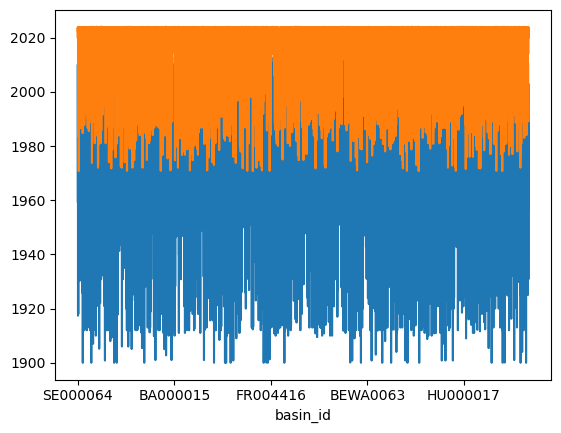

In [33]:
network_estreams_filtered.start_date.plot()
network_estreams_filtered.end_date.plot()

- Check out how were our choices regarding the duplicates deletion

In [34]:
# Network kept to the analysis
network_estreams_filtered.loc["ITLI0307", ["num_years", "start_date", "end_date","duplicated_suspect"]]

num_years                               63
start_date             1930-01-01 00:00:00
end_date               2023-05-31 00:00:00
duplicated_suspect    [ITTO0386, ITTO0389]
Name: ITLI0307, dtype: object

In [35]:
# Duplicated deleted:
network_estreams.loc["ITTO0386", ["num_years", "start_date", "end_date","duplicated_suspect"]]

num_years                               9
start_date            2013-10-31 00:00:00
end_date              2021-06-30 00:00:00
duplicated_suspect           ['ITLI0307']
Name: ITTO0386, dtype: object

In [36]:
# Duplicated deleted:
network_estreams.loc["ITTO0389", ["num_years", "start_date", "end_date","duplicated_suspect"]]

num_years                              32
start_date            1951-01-01 00:00:00
end_date              2014-12-31 00:00:00
duplicated_suspect           ['ITLI0307']
Name: ITTO0389, dtype: object

- Final number of catchments per country

In [37]:
network_estreams_filtered.groupby('gauge_country').size()

gauge_country
AT     419
BA      31
BE     166
BY       5
CH     164
CY      13
CZ     388
DE    1436
DK     204
EE      47
ES     835
FI     354
FR    2346
GB     498
GR       2
HR     173
HU      76
IE     194
IS      17
IT     367
LT      42
LU      17
LV      12
MD       2
MK       1
NI      44
NL       7
NO      55
PL     863
PT     154
RO      17
RS      18
RU      52
SE     192
SI      73
SK      20
TR      20
UA      16
dtype: int64

## Plot variables

In [38]:
# Load the world shapefile dataset provided by GeoPandas
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Set font properties using rcParams
mpl.rcParams['font.family'] = 'helvetica'  # Change the font family
mpl.rcParams['font.size'] = 8          # Change the font size
mpl.rcParams['font.weight'] = 'bold'  # Change font weight (e.g., 'bold', 'normal')
mpl.rcParams['axes.labelweight'] = 'bold'  # Change label font weight (e.g., 'bold', 'normal')

#### Here we define the color categories and apply the color_mapping_list function

In [42]:
# Defining the colour categories and mapping lists
color_categories_q_mean = [(-np.inf, 0.5), (0.5, 1.0), (1.0, 1.5), (1.5, 2.0), (2.0, np.inf)]
color_categories_q_runoff_ratio = [(-np.inf, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_q_elas_Sankarasubramanian = [(-np.inf, 0.5), (0.5, 1.0), (1.0, 1.5), (1.5, 2.0), (2.0, np.inf)]
color_categories_slope_sawicz = [(-np.inf, 1.0), (1.0, 1.5), (1.5, 2.0), (2.0, 2.5), (2.5, np.inf)]
color_categories_baseflow_index = [(-np.inf, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_hfd_mean = [(-np.inf, 100), (100, 150), (150, 200), (200, 250), (250, np.inf)]
color_categories_q_5 = [(-np.inf, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_q_95 = [(-np.inf, 2.0), (2.0, 4.0), (4.0, 6.0), (6.0, 8.0), (8.0, np.inf)]
color_categories_hq_freq = [(-np.inf, 10), (10, 15), (15, 20), (20, 25), (25, np.inf)]
color_categories_hq_dur = [(-np.inf, 2), (2, 4), (4, 6), (6, 8), (8, np.inf)]
color_categories_lq_freq = [(-np.inf, 25), (25, 50), (50, 75), (75, 100), (100, np.inf)]
color_categories_lq_dur = [(-np.inf, 10), (10, 20), (20, 30), (30, 40), (40, np.inf)]
color_categories_p_mean = [(-np.inf, 1), (1, 2), (2, 3), (3, 4), (4, np.inf)]
color_categories_pet_mean = [(-np.inf, 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, np.inf)]
color_categories_aridity = [(-np.inf, 0.5), (0.5, 1.0), (1.0, 1.5), (1.5, 2.0), (2.0, np.inf)]
color_categories_p_seasonality = [(-np.inf, -0.75), (-0.75, -0.5), (-0.5, 0.0), (0.0, 0.5), (0.5, np.inf)]
color_categories_frac_snow = [(-np.inf, 0.05), (0.05, 0.1), (0.1, 0.15), (0.15, 0.2), (0.2, np.inf)]
color_categories_hp_freq = [(-np.inf, 5), (5, 10), (10, 15), (15, 20), (20, np.inf)]
color_categories_hp_dur = [(-np.inf, 1.2), (1.2, 1.4), (1.4, 1.6), (1.6, 1.8), (1.8, np.inf)]
color_categories_lp_freq = [(-np.inf, 175), (175, 200), (200,225), (225, 250), (250, np.inf)]
color_categories_lp_dur = [(-np.inf, 4), (4, 6), (6, 8), (8, 10), (10, np.inf)]
color_categories_ele_mt_max = [(-np.inf, 1000), (1000, 2000), (2000, 3000), (3000, 4000), (4000, np.inf)]
color_categories_ele_mt_mean = [(-np.inf, 500), (500, 1000), (1000, 1500), (1500, 2000), (2000, np.inf)]
color_categories_slp_dg_mean = [(-np.inf, 5), (5, 10), (10, 15), (15, 20), (20, np.inf)]
color_categories_elon_ratio = [(-np.inf, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, np.inf)]
color_categories_bedrk_dep = [(-np.inf, 5), (5, 10), (10, 15), (15, 20), (20, np.inf)]
color_categories_perc_low_perm = [(-np.inf, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_perc_medium_perm = [(-np.inf, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_perc_high_perm = [(-np.inf, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_root_dep_mean = [(-np.inf, 40), (40, 60), (60, 80), (80, 100), (100, np.inf)]
color_categories_soil_tawc_mean = [(-np.inf, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_soil_fra_sand_mean = [(-np.inf, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_soil_fra_silt_mean = [(-np.inf, 10), (10, 20), (20, 30), (30, 40), (40, np.inf)]
color_categories_soil_fra_clay_mean = [(-np.inf, 10), (10, 20), (20, 30), (30, 40), (40, np.inf)]
color_categories_soil_fra_grav_mean = [(-np.inf, 5), (5, 10), (10, 15), (15, 20), (20, np.inf)]
color_categories_lai_mean = [(-np.inf, 0.1), (0.1, 0.15), (0.15, 0.2), (0.2, 0.25), (0.25, np.inf)]
color_categories_ndvi_mean = [(-np.inf, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6, np.inf)]
color_categories_lulc_2006_urban = [(-np.inf, 0.05), (0.05, 0.1), (0.1, 0.15), (0.15, 0.2), (0.2, np.inf)]
color_categories_lulc_2006_NonIrriAgri = [(-np.inf, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_lulc_2006_Agric = [(-np.inf, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_lulc_2006_forest = [(-np.inf, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_lulc_2006_grass = [(-np.inf, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_lulc_2006_agriculture = [(-np.inf, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_dam_num = [(-np.inf, 0), (0, 1), (1, 2), (2, 3), (3, np.inf)]
color_categories_lakes_num = [(-np.inf, 0), (0, 1), (1, 2), (2, 3), (3, np.inf)]
color_categories_area = [(-np.inf, 100), (100, 250), (250, 500), (500, 1000), (1000, np.inf)]

# Color mapping list
color_mapping_list = {
    "q_mean":  generate_legend_and_color_mapping("Q [mm/day]", color_categories_q_mean, 0, 10, 1, 10, color_palette='blues'),
    "q_runoff_ratio": generate_legend_and_color_mapping("Q/P [-]", color_categories_q_runoff_ratio, 0, 2, 0.5, 10),
    "q_elas_Sankarasubramanian": generate_legend_and_color_mapping("Q-Elasticity [-]", color_categories_q_elas_Sankarasubramanian, -2, 5, 1, 10),
    "slope_sawicz": generate_legend_and_color_mapping("FDC-Slope[-]", color_categories_slope_sawicz, 0, 10, 0.5, 10),
    "baseflow_index": generate_legend_and_color_mapping("BFI [-]", color_categories_baseflow_index, 0, 1, 0.2, 10),
    "hfd_mean": generate_legend_and_color_mapping("HFD [day]", color_categories_hfd_mean, 100, 300, 50, 10),
    "q_5":  generate_legend_and_color_mapping("Q5 [mm/day]", color_categories_q_5, 0, 2, 0.25, 10, color_palette='blues'),
    "q_95":  generate_legend_and_color_mapping("Q95 [mm/day]", color_categories_q_95, 0, 20, 2, 10, color_palette='blues'),
    "hq_freq":  generate_legend_and_color_mapping("HQ freq. [days/year]", color_categories_hq_freq, 0, 100, 1, 10),
    "hq_dur":  generate_legend_and_color_mapping("HQ dur. [days]", color_categories_hq_dur, 0, 30, 1, 10),
    "lq_freq":  generate_legend_and_color_mapping("LQ freq. [day/year]", color_categories_lq_freq, 0, 350, 50, 10, color_palette='custom'),
    "lq_dur":  generate_legend_and_color_mapping("LQ dur. [days]", color_categories_lq_dur, 0, 150, 1, 10, color_palette='custom'),
    "p_mean":  generate_legend_and_color_mapping("P [mm/day]", color_categories_p_mean, 0, 10, 1, 10, color_palette='blues'),
    "pet_mean":  generate_legend_and_color_mapping("PET [mm/day]", color_categories_pet_mean, 0, 10, 1, 10, color_palette='custom'),
    "aridity": generate_legend_and_color_mapping("Aridity [-]", color_categories_aridity, 0, 5, 1, 10, color_palette='custom'),
    "p_seasonality":  generate_legend_and_color_mapping("P-Seasonality [-]", color_categories_p_seasonality, 0, 10, 1, 10, color_palette='default'),
    "frac_snow":  generate_legend_and_color_mapping("Snow frac. [-]", color_categories_frac_snow, 0, 10, 1, 10, color_palette='default'),
    "hp_freq":  generate_legend_and_color_mapping("HP freq. [days/year]", color_categories_hp_freq, 0, 10, 1, 10, color_palette='default'),
    "hp_dur": generate_legend_and_color_mapping("HP dur. [days]", color_categories_hp_dur, 0, 5, 1, 10, color_palette='default'),
    "lp_freq":  generate_legend_and_color_mapping("LP freq. [days/year]", color_categories_lp_freq, 0, 10, 0.2, 10, color_palette='default'),
    "lp_dur":  generate_legend_and_color_mapping("LP dur. [days]", color_categories_lp_dur, 0, 10, 1, 10, color_palette='default'),
    "ele_mt_max":  generate_legend_and_color_mapping("Elev-max [m]", color_categories_ele_mt_max, 0, 10, 1, 10, color_palette='default'),
    "ele_mt_mean":  generate_legend_and_color_mapping("Mean elev. [m]", color_categories_ele_mt_mean, 0, 10, 1, 10, color_palette='default'),
    "slp_dg_mean":  generate_legend_and_color_mapping("Mean slope [d]", color_categories_slp_dg_mean, 0, 10, 1, 10, color_palette='default'),
    "elon_ratio":  generate_legend_and_color_mapping("Elon. ratio [-]", color_categories_elon_ratio, 0, 10, 1, 10, color_palette='default'),
    "bedrk_dep":  generate_legend_and_color_mapping("Bedrock depth [m]", color_categories_bedrk_dep, 0, 10, 1, 10, color_palette='default'),        
    "perc_low_perm":  generate_legend_and_color_mapping("Low perm. [%]", color_categories_perc_low_perm, 0, 10, 1, 10, color_palette='default'),
    "perc_medium_perm":  generate_legend_and_color_mapping("Medium perm. [%]", color_categories_perc_medium_perm, 0, 10, 1, 10, color_palette='default'),
    "perc_high_perm":  generate_legend_and_color_mapping("High perm. [%]", color_categories_perc_high_perm, 0, 10, 1, 10, color_palette='default'),
    "root_dep_mean":  generate_legend_and_color_mapping("Root depth [cm]", color_categories_root_dep_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_tawc_mean":  generate_legend_and_color_mapping("TAWC [cm]", color_categories_soil_tawc_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_fra_sand_mean":  generate_legend_and_color_mapping("Sand [%]", color_categories_soil_fra_sand_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_fra_silt_mean":  generate_legend_and_color_mapping("Silt [%]", color_categories_soil_fra_silt_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_fra_clay_mean":  generate_legend_and_color_mapping("Clay [%]", color_categories_soil_fra_clay_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_fra_grav_mean":  generate_legend_and_color_mapping("Gravel [%]", color_categories_soil_fra_grav_mean, 0, 10, 1, 10, color_palette='default'),
    "lai_mean":  generate_legend_and_color_mapping("LAI [-]", color_categories_lai_mean, 0, 10, 1, 10, color_palette='vegetation'),
    "ndvi_mean":  generate_legend_and_color_mapping("NDVI [-]", color_categories_ndvi_mean, 0, 10, 1, 10, color_palette='vegetation'),
    "lulc_2006_urban":  generate_legend_and_color_mapping("Urban [-]", color_categories_lulc_2006_urban, 0, 10, 1, 10, color_palette='custom'),
    "lulc_2006_NonIrriAgri":  generate_legend_and_color_mapping("Agriculture [-]", color_categories_lulc_2006_NonIrriAgri, 0, 10, 1, 10, color_palette='custom'),
    "lulc_2006_Agric":  generate_legend_and_color_mapping("Agriculture [-]", color_categories_lulc_2006_Agric, 0, 10, 1, 10, color_palette='custom'),
    "lulc_2006_forest":  generate_legend_and_color_mapping("Forests [-]", color_categories_lulc_2006_forest, 0, 10, 1, 10, color_palette='vegetation'),
    "lulc_2006_grass":  generate_legend_and_color_mapping("Grasslands [-]", color_categories_lulc_2006_grass, 0, 10, 1, 10, color_palette='custom'),
    "lulc_2006_agriculture":  generate_legend_and_color_mapping("Agriculture [-]", color_categories_lulc_2006_agriculture, 0, 10, 1, 10, color_palette='custom'),
    "dam_num":  generate_legend_and_color_mapping("Dams [-]", color_categories_dam_num, 0, 10, 1, 10, color_palette='default'),
    "lakes_num":  generate_legend_and_color_mapping("Lakes [-]", color_categories_lakes_num, 0, 10, 1, 10, color_palette='default'),
    "area_estreams":  generate_legend_and_color_mapping("Area [km2]", color_categories_area, 0, 10, 1, 10, color_palette='default'),
}

In [34]:
network_estreams_filtered.columns

Index(['gauge_id', 'gauge_name', 'gauge_country', 'gauge_provider', 'river',
       'lon_snap', 'lat_snap', 'lon', 'lat', 'elevation', 'area_official',
       'area_estreams', 'area_flag', 'area_rel', 'start_date', 'end_date',
       'num_years', 'num_months', 'num_days', 'num_continuous_days',
       'num_days_gaps', 'num_days_reliable', 'num_days_noflag',
       'num_days_suspect', 'gauge_flag', 'duplicated_suspect',
       'watershed_group', 'gauges_upstream', 'nested_catchments', 'q_mean',
       'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time',
       'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep', 'perc

<Axes: >

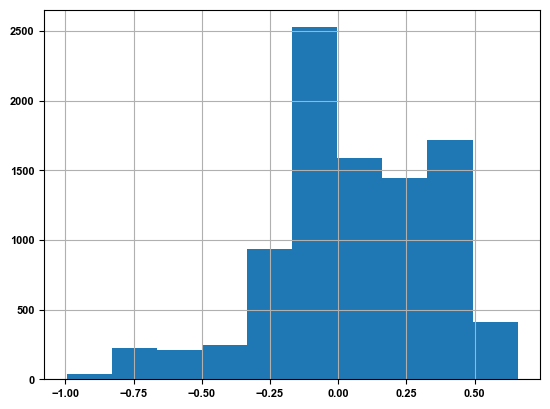

In [41]:
network_estreams_filtered["p_seasonality"].hist()

### Observation:
- If by any chance you get the error: "ValueError: aspect must be finite and positive", you should adjust the color_categories_{variable} varaibles.
- For example:
    - From: color_categories_dam_num = [(-np.inf, 0), (0, 1), (1, 10), (10, 50), (50, np.inf)]
    - To: color_categories_dam_num = [(-np.inf, 0), (0, 1), (1, 2), (2, 3), (3, np.inf)]
- Use the estreams_attributes[{variable}].hist() to investigate an adequate interval.

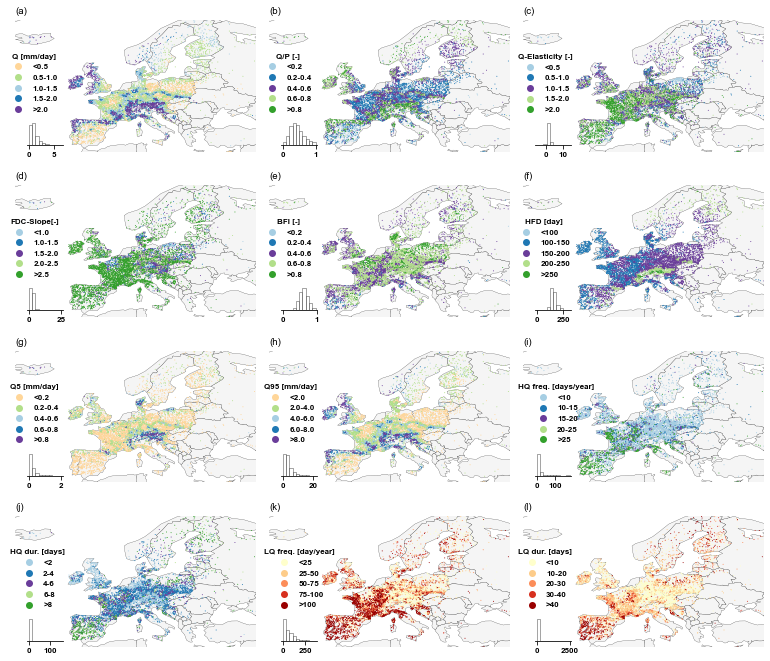

In [128]:
# List of variables
variable_list = ["q_mean", "q_runoff_ratio", "q_elas_Sankarasubramanian", "slope_sawicz", "baseflow_index", "hfd_mean", "q_5", "q_95", 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur']

# Create a subplot grid
num_variables = len(variable_list)
num_cols = 3
num_rows = math.ceil(num_variables / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(10.7, 9.3), gridspec_kw={'height_ratios': [1]*num_rows})
axs = axs.flatten()

for i, variable in enumerate(variable_list):
    plot_variable_subplot(axs[i], variable, network_estreams_filtered, color_mapping_list, gdf)
    axs[i].set_title(f'({chr(97+i)})', loc="left")  # Add subplot title with letter indexing

# Adjust layout and remove space between subplots
plt.tight_layout()

# Save or display the plot
plt.show()

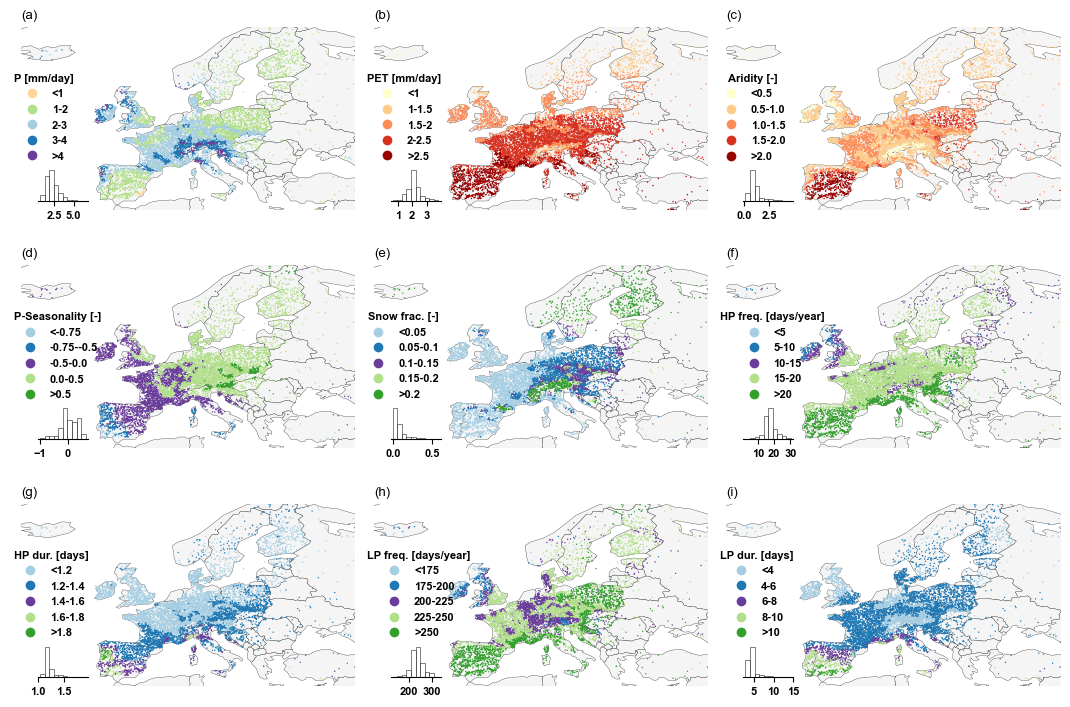

In [43]:
# List of variables
variable_list = ['p_mean', 'pet_mean', 'aridity', 'p_seasonality', 'frac_snow', "hp_freq", "hp_dur", "lp_freq", "lp_dur"]

# Create a subplot grid
num_variables = len(variable_list)
num_cols = 3
num_rows = math.ceil(num_variables / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(10.7, 7.3), gridspec_kw={'height_ratios': [1]*num_rows})
axs = axs.flatten()

for i, variable in enumerate(variable_list):
    plot_variable_subplot(axs[i], variable, network_estreams_filtered, color_mapping_list, gdf)
    axs[i].set_title(f'({chr(97+i)})', loc="left")  # Add subplot title with letter indexing

# Adjust layout and remove space between subplots
plt.tight_layout()

# Save or display the plot
plt.show()

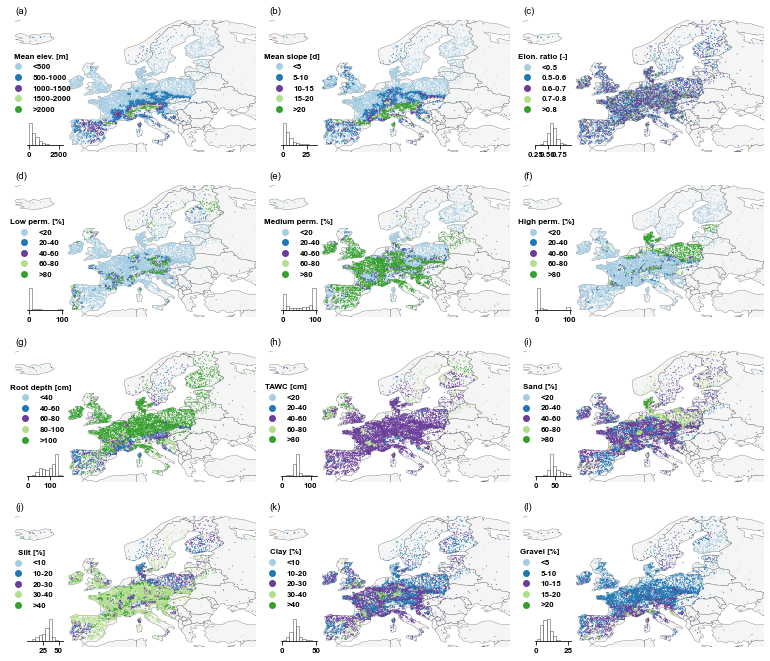

In [130]:
# List of variables
variable_list = ['ele_mt_mean', 'slp_dg_mean', 'elon_ratio', 'perc_low_perm', 'perc_medium_perm', 'perc_high_perm', 'root_dep_mean', 
                 'soil_tawc_mean', 'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean', 'soil_fra_grav_mean']

# Create a subplot grid
num_variables = len(variable_list)
num_cols = 3
num_rows = math.ceil(num_variables / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(10.7, 9.3), gridspec_kw={'height_ratios': [1]*num_rows})
axs = axs.flatten()

for i, variable in enumerate(variable_list):
    plot_variable_subplot(axs[i], variable, network_estreams_filtered, color_mapping_list, gdf)
    axs[i].set_title(f'({chr(97+i)})', loc="left")  # Add subplot title with letter indexing

# Adjust layout and remove space between subplots
plt.tight_layout()

# Save or display the plot
plt.show()

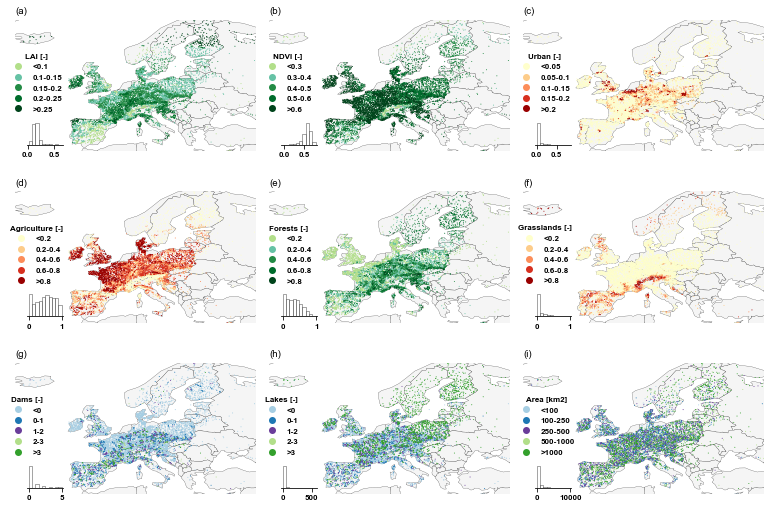

In [131]:
# List of variables
variable_list = ['lai_mean', 'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_agriculture',
       'lulc_2006_forest', 'lulc_2006_grass', 'dam_num', 'lakes_num', 'area_estreams']

# Create a subplot grid
num_variables = len(variable_list)
num_cols = 3
num_rows = math.ceil(num_variables / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(10.7, 7.3), gridspec_kw={'height_ratios': [1]*num_rows})
axs = axs.flatten()

for i, variable in enumerate(variable_list):
    plot_variable_subplot(axs[i], variable, network_estreams_filtered, color_mapping_list, gdf)
    axs[i].set_title(f'({chr(97+i)})', loc="left")  # Add subplot title with letter indexing

# Adjust layout and remove space between subplots
plt.tight_layout()

# Save or display the plot
plt.show()


## Export subset
- Here we export our subset of data (i.e., timeseries_discharge and network_attributes).

In [ ]:
# timeseries_discharge = timeseries_discharge.loc[:, estreams_attributes.index]
# timeseries_discharge

In [44]:
# timeseries_discharge.to_csv("results/timeseries_discharge.csv")
network_estreams_filtered.to_csv("data/exploration/estreams_attributes_filtered_moselle_3.csv", encoding='utf-8')

# End